# Download SDSS data


- download SDSS spectra for each index in the `mpa` dataframe

In [44]:
import pickle as pcl
import os
import sys

import numpy as np
import pandas as pd
from astropy.io import fits

from scipy.stats import binned_statistic_2d

import astropy.units as u
from astropy.cosmology import Planck13 as cosmo

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
import matplotlib as mpl

from predict import predict
import extinction

R_V = 3.2

fetch mpa dataframe

In [45]:
mpa = pcl.load(open('data/mpa_df.p','rb'))

## Fetch spectra from file

In [46]:
# redshift_arr = []
# spec_arr = []
# noise_arr = []
# wavelength_arr = []
# mpa_index_arr = []
# filename_arr = []

# direc='data/SDSSspec/'
# for i,filename in enumerate(os.listdir(direc)):
#     with fits.open(direc+filename) as hdu:
        
#         if i%1000 == 0: print("%.2f%%"%(float(i)*100/len(os.listdir(direc))))
        
#         if hdu[0].header['Z_CONF'] < 0.95:
#             continue
            

#         if hdu[0].header['FBADPIX'] > 0.1:
#             continue
            

#         z = hdu[0].header['Z']
#         print(z)
#         spec = hdu[0].data[0]
#         noise = hdu[0].data[2]
#         mask = hdu[0].data[3]
#         wavelength = 10 ** (hdu[0].header['COEFF0'] + hdu[0].header['COEFF1'] * np.arange(len(spec)))
#         mask = np.in1d(mask, [0]) # emission lines: int(0x40000000)
        
#         if np.sum(mask) == 0.:
#             continue
            
            
#         index = mpa.loc[(mpa['plate'] == hdu[0].header['PLATEID']) &\
#                        (mpa['mjd'] == hdu[0].header['MJD']) &\
#                        (mpa['fiberid'] == hdu[0].header['FIBERID'])].index

#         if len(index) > 0:
#             filename_arr.append(filename)
#             mpa_index_arr.append(index)
#             wavelength_arr.append(wavelength[mask])
#             spec_arr.append(spec[mask])
#             noise_arr.append(noise[mask])
#             redshift_arr.append(z)


# nan_corrections = [i for i,item in enumerate(mpa_index_arr) \
#                    if item[0] in np.where(np.isnan(mpa['mass_correction']))[0]]

# for n in nan_corrections:
#     del mpa_index_arr[n]
#     del wavelength_arr[n]
#     del spec_arr[n]
#     del noise_arr[n]
#     del redshift_arr[n] 

# pcl.dump([mpa_index_arr, wavelength_arr, spec_arr, noise_arr, redshift_arr], 
#          open('data/spec_pickles.p','wb'))

In [47]:
# mpa_index_arr, wavelength_arr, spec_arr, noise_arr, redshift_arr =\
#     pcl.load(open('data/spec_pickles.p','rb'))

mpa_index_arr, wavelength_arr, spec_arr, noise_arr, redshift_arr =\
    pcl.load(open('data/spec_pickles_neb.p','rb'))

Filter by wavelength

65884 73717


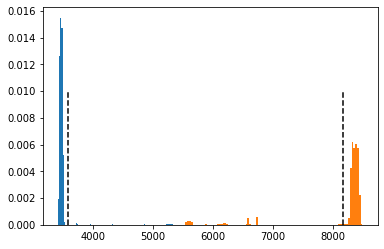

In [48]:
new_wl = np.loadtxt('data/wavelength_grid.txt')
w_min_val = np.min(new_wl)
w_max_val = np.max(new_wl)

w_min = np.array([w.min() / (1+z) for i, (w, z) in enumerate(zip(wavelength_arr, redshift_arr))])
w_max = np.array([w.max() / (1+z) for i, (w, z) in enumerate(zip(wavelength_arr, redshift_arr))])

wl_mask = (w_min < w_min_val) & (w_max > w_max_val)
print(np.sum(wl_mask), len(wl_mask))

plt.hist(w_min, bins=100, density=True);
plt.vlines(w_min_val, 0, 0.01, linestyle='dashed')

plt.hist(w_max, bins=100, density=True);
plt.vlines(w_max_val, 0, 0.01, linestyle='dashed')

In [49]:
mpa_index_arr = np.array(mpa_index_arr)[wl_mask]
wavelength_arr = np.array(wavelength_arr)[wl_mask]
spec_arr = np.array(spec_arr)[wl_mask]
noise_arr = np.array(noise_arr)[wl_mask]
redshift_arr = np.array(redshift_arr)[wl_mask]

Get filters from sim instance

In [50]:
from predict import predict
si = predict(fname='data/full_histories_illustris.h5')

f1 = si.filters['SDSS_g']
f2 = si.filters['SDSS_r']

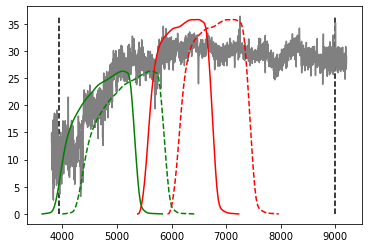

In [51]:
i = 200
s = spec_arr[i]
wavelength = wavelength_arr[i]
z = redshift_arr[i]

plt.plot(wavelength, s, c='grey')

scaling = np.max(s) * 2

plt.vlines(w_min_val * (1+z), 0, scaling / 2, linestyle='dashed')
plt.vlines(w_max_val * (1+z), 0, scaling / 2, linestyle='dashed')

plt.plot(np.array(f1.wavelength), f1.transmit * scaling, c='g')
plt.plot(np.array(f2.wavelength), f2.transmit * scaling, c='r')

plt.plot(np.array(f1.wavelength) * (1+z), f1.transmit * scaling, ls='dashed', c='g')
plt.plot(np.array(f2.wavelength) * (1+z), f2.transmit * scaling, ls='dashed', c='r')

## Calculate colours

In [68]:
def restframe_flux(spec, wl, z):
    spec *= 1e-17  # erg s^-1 cm^-2 AA^-1
    spec *= (cosmo.luminosity_distance(z).to(u.pc).value / 10)**2  # erg s^-1 cm^-2 AA^-1
    spec /= (1+z)
    
    spec *= wl**2 / 2.9979e18  # erg s^-1 cm^-2 Hz^-1
    spec /= (1+z)**2  # restframe wavelength
    return spec


M_g = np.array([None] * len(spec_arr), dtype=float)
M_r = np.array([None] * len(spec_arr), dtype=float)

for i in np.arange(len(spec_arr)):

    s = spec_arr[i].copy()
    s_error = noise_arr[i].copy()
    z = redshift_arr[i]
    wavelength = wavelength_arr[i].copy()
    
    A_V = mpa.loc[mpa_index_arr[i]]['E_BV_SFD'] * R_V
    e = extinction.odonnell94(wavelength, A_V, R_V)
#     e = extinction.calzetti00(wavelength, A_V, R_V)
    trans = 10**(0.4 * e)

    s *= trans
    s *= mpa.loc[mpa_index_arr[i]]['spectra_correction']#.values
    s = restframe_flux(s, wavelength, z)

    # RESTFRAME filter
    M_g[i] = si.photo(s, wavelength, f1.transmit, f1.wavelength * (1+z))[0]
    M_r[i] = si.photo(s, wavelength, f2.transmit, f2.wavelength * (1+z))[0]


In [71]:
M_mask = ~np.isnan(M_g) & ~np.isnan(M_r)

mpa_index_arr = mpa_index_arr[M_mask]
wavelength_arr = wavelength_arr[M_mask]
spec_arr = spec_arr[M_mask]
noise_arr = noise_arr[M_mask]
redshift_arr = redshift_arr[M_mask]
M_g = M_g[M_mask]
M_r = M_r[M_mask]

## Interpolate negative fluxes

In [72]:
def interp_negative(spec, wl):
    mask = spec < 0
    vals = np.interp(wl[mask],
                     wl[~mask],
                     spec[~mask])
    spec[mask] = vals
    return spec


interpd = [np.sum(s < 0) < 1 for s in spec_arr]

for i, spec in enumerate(spec_arr):
    spec_arr[i] = interp_negative(spec, wavelength_arr[i])

In [73]:
pcl.dump([mpa_index_arr, wavelength_arr, spec_arr, noise_arr, redshift_arr, M_g, M_r], 
         open('data/spec_pickles_selection.p','wb'))